## Temporal clustering

In [5]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts", "lib"))


import numpy as np
import pandas as pd
from cov_functions import *
from clustering_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
from tslearn.utils import to_time_series
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

import tslearn as tsl

mapdict = {'TF3_NegativeAffect': 'TF3',
        'TF2_PhysiolAnx': 'TF2', 
        'TF1_CognAnxDepr': 'TF1',
        'stai_ta': "TA",
        'covid_worry': 'Worry', 
        'prob_est': 'Probest',
        'q7_worry_econ_impact': 'EconWorr',
        'q6_apply_soc_dist': 'SocialDist',
        'q6_risk_group': 'RiskGr',
        'avoid_beh': 'AvoidBeh',
        'avoid_anx': 'AvoidAnx',
        'q6_media_freq_num': 'InforSeek',
        'q6_media_valence': 'MediaVal',
        'q7_period_rel_danger': 'DangerSate',
        'deaths': 'Deaths',
        'cases': 'Cases',
        'worryhealth': 'HealthWorry',
        'q6_work_home': "WorkHome",
        'sticsa_som_sa_currsess': "StateSomAnx",
    #    "q6_close_person_infdied": "ClosePDied",
        "covid_thoughts": "CovThoughts", 
        "memory_worry_infected_baselined": "MemWorry", 
        "memory_prob_infected_baselined": "MemProb", 

        #"affheallth-econ-worry": "Health>Econ \n worry", 
        #"covid_cases_est_diff": "Estimate of \n covid cases"
        }


# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
#df = df.query('sr_age>18 & sr_age<42')
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

df=df.rename(columns=mapdict)
dfall = df.copy()

#df.loc[:,vars] = df.loc[:,vars].apply(zscore, nan_policy='omit')
#df = df.loc[:,vars+["PROLIFICID","session"]]
#tdf = df.pivot(columns="session", index="PROLIFICID", values=vars)


id_df = dfall.loc[:,["PROLIFICID","TF3", "TF2", "TF1", "TA"]].groupby(by=["PROLIFICID"]).mean()
#df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_1.csv"))

##### VERY IMPORTANT ####



vars = ["AvoidBeh", "InforSeek", "Probest", 
        "DangerSate"]


### Meta parameters
corr_type = "spearman" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic"]
    
print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 3
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
        tf_short = ["TF1", "TF2", "TF3"]
elif no_trait_factors==4:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 

#tf_short = ["TF1", "TF2", "TF3", "sr_age", "q6_me_inf", "q6_close_person_inf", "q6_close_person_died", "WorkHome", "SocialDist", "RiskGr", "q6_houshold_membs", "Cases", "Deaths", "TA", "sticsa_ta", "sticsa_cog_ta", "sticsa_som_ta", "bdi", "cat"]

    

/data/drive/postdoc/Project4_covid
State seveirty NaNs: 198 out of entries: 5825


In [11]:
df.query('sr_age>18 & sr_age<42')

PROLIFICID      PROLIFICID.1 GROUP  session  index  submitdate  \
0     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        1    217  2020-04-18   
1     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        2    603  2020-05-04   
2     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        3    690  2020-05-18   
3     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        4    980  2020-06-01   
4     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        5   1456  2020-06-15   
...                ...               ...   ...      ...    ...         ...   
5820  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       16   4071  2020-10-19   
5821  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       17   4335  2020-11-02   
5822  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       18   4531  2020-11-16   
5823  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       19   4840  2020-12-01   
5824  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       20   4968  2020-12-14   

      lastpage  sr_age sr_gender sr_postcode  ...  stai_ta_ms  stai_ta_ts  \
0         12.0    32.0         F      DY98SN  ...        high         mid   
1          8.0    32.0         F      DY98SN  ...        high         mid   
2          8.0    32.0         F      DY98SN  ...        high         mid   
3          8.0    32.0         F         DY9  ...        high         mid   
4          8.0    32.0         F         DY9  ...        high         mid   
...        ...     ...       ...         ...  ...         ...         ...   
5820       8.0    37.0         M      CW55UG  ...         low         low   
5821       7.0    37.0         M      CW55UG  ...         low         low   
5822       8.0    37.0         M      CW55UG  ...         low         low   
5823       7.0    37.0         M      CW55UG  ...         low         low   
5824      12.0    37.0         M      CW55UG  ...         low         low   

      TF1_CognAnxDepr_ms  TF1_CognAnxDepr_ts  TF3_NegativeAffect_ms  \
0                   high                 mid                    low   
1                   high                 mid                    low   
2                   high                 mid                    low   
3                   high                 mid                    low   
4                   high                 mid                    low   
...                  ...                 ...                    ...   
5820                 low                 low                    low   
5821                 low                 low                    low   
5822                 low                 low                    low   
5823                 low                 low                    low   
5824                 low                 low                    low   

      TF3_NegativeAffect_ts  TF2_PhysiolAnx_ms  TF2_PhysiolAnx_ts     Cases  \
0                       mid                low                mid -0.372347   
1                       mid                low                mid -0.373410   
2                       mid                low                mid -0.524375   
3                       mid                low                mid -0.625373   
4                       mid                low                mid -0.657268   
...                     ...                ...                ...       ...   
5820                    low               high                mid  1.172261   
5821                    low               high                mid  1.895877   
5822                    low               high                mid  1.953767   
5823                    low               high                mid  0.777252   
5824                    low               high                mid  0.629123   

        Deaths  
0     2.467453  
1     0.779438  
2    -0.141298  
3    -0.524938  
4    -0.601666  
...        ...  
5820 -0.630535  
5821 -0.549044  
5822 -0.182336  
5823  0.021391  
5824  0.836299  

[5759 rows x 315 columns]

In [12]:
df

PROLIFICID      PROLIFICID.1 GROUP  session  index  submitdate  \
0     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        1    217  2020-04-18   
1     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        2    603  2020-05-04   
2     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        3    690  2020-05-18   
3     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        4    980  2020-06-01   
4     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        5   1456  2020-06-15   
...                ...               ...   ...      ...    ...         ...   
5820  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       16   4071  2020-10-19   
5821  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       17   4335  2020-11-02   
5822  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       18   4531  2020-11-16   
5823  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       19   4840  2020-12-01   
5824  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       20   4968  2020-12-14   

      lastpage  sr_age sr_gender sr_postcode  ...  stai_ta_ms  stai_ta_ts  \
0         12.0    32.0         F      DY98SN  ...        high         mid   
1          8.0    32.0         F      DY98SN  ...        high         mid   
2          8.0    32.0         F      DY98SN  ...        high         mid   
3          8.0    32.0         F         DY9  ...        high         mid   
4          8.0    32.0         F         DY9  ...        high         mid   
...        ...     ...       ...         ...  ...         ...         ...   
5820       8.0    37.0         M      CW55UG  ...         low         low   
5821       7.0    37.0         M      CW55UG  ...         low         low   
5822       8.0    37.0         M      CW55UG  ...         low         low   
5823       7.0    37.0         M      CW55UG  ...         low         low   
5824      12.0    37.0         M      CW55UG  ...         low         low   

      TF1_CognAnxDepr_ms  TF1_CognAnxDepr_ts  TF3_NegativeAffect_ms  \
0                   high                 mid                    low   
1                   high                 mid                    low   
2                   high                 mid                    low   
3                   high                 mid                    low   
4                   high                 mid                    low   
...                  ...                 ...                    ...   
5820                 low                 low                    low   
5821                 low                 low                    low   
5822                 low                 low                    low   
5823                 low                 low                    low   
5824                 low                 low                    low   

      TF3_NegativeAffect_ts  TF2_PhysiolAnx_ms  TF2_PhysiolAnx_ts     Cases  \
0                       mid                low                mid -0.372347   
1                       mid                low                mid -0.373410   
2                       mid                low                mid -0.524375   
3                       mid                low                mid -0.625373   
4                       mid                low                mid -0.657268   
...                     ...                ...                ...       ...   
5820                    low               high                mid  1.172261   
5821                    low               high                mid  1.895877   
5822                    low               high                mid  1.953767   
5823                    low               high                mid  0.777252   
5824                    low               high                mid  0.629123   

        Deaths  
0     2.467453  
1     0.779438  
2    -0.141298  
3    -0.524938  
4    -0.601666  
...        ...  
5820 -0.630535  
5821 -0.549044  
5822 -0.182336  
5823  0.021391  
5824  0.836299  

[5825 rows x 315 columns]

### variables of interest

<AxesSubplot:>

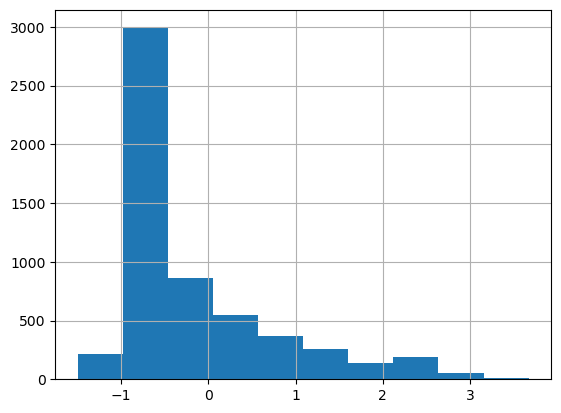

In [6]:
df.Deaths.hist()

### determining number of clusters 

In [7]:
run_cluster_size_estimation = False

if run_cluster_size_estimation:
    cldata = pd.DataFrame()
    #depvar = "F1_CovidAnxietyWorry"

    for depvar in vars:
        tdf = df.loc[:,[depvar]+["session", "PROLIFICID"]]
        tdf = tdf.pivot(index='PROLIFICID', columns='session', values=depvar).add_prefix('sess')

        # Vrey important, otherwise clustering doesn't work! 
        tdf = tdf.interpolate(method='linear', axis=1)

        # Turn to timeseries data type
        ts = tsl.utils.to_time_series(tdf)

        #tdf, m = estimate_clusters(ts, n_clusters=cl, metric="euclidean")
        #print("c="+str(cl) + " S="+ str(silhouette_score(ts,tdf.cl, metric="euclidean")))
        print(depvar)
        ssc =[]
        clsize = range(2,6)
        for nc in clsize:
            tdf, m = estimate_clusters(ts,tdf, n_clusters=nc, metric="euclidean")
            sc = silhouette_score(ts,tdf.cl, metric="euclidean")
            ssc.append(sc)
            print("c="+str(nc) + " S="+ str(sc))
        cldata = pd.concat([cldata, pd.DataFrame({'var':depvar, 'noclusters':[clsize[np.argmax(ssc)]]})], axis=0)
    cldata.to_csv(os.path.join(root_dir, "data", "number_of_cluster_data.csv"))
else:
    cldata = pd.read_csv(os.path.join(root_dir, "data", "number_of_cluster_data.csv"))

### Clusters estimated by silhouette
- most variables have two large clusters

AvoidBeh
InforSeek
Probest
DangerSate


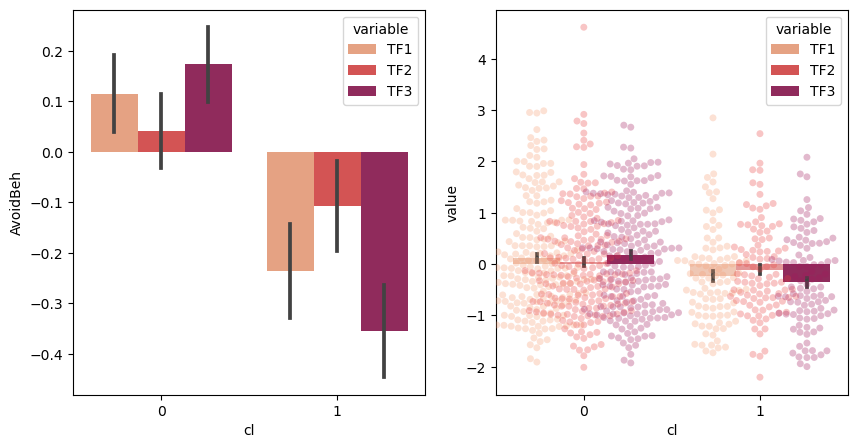

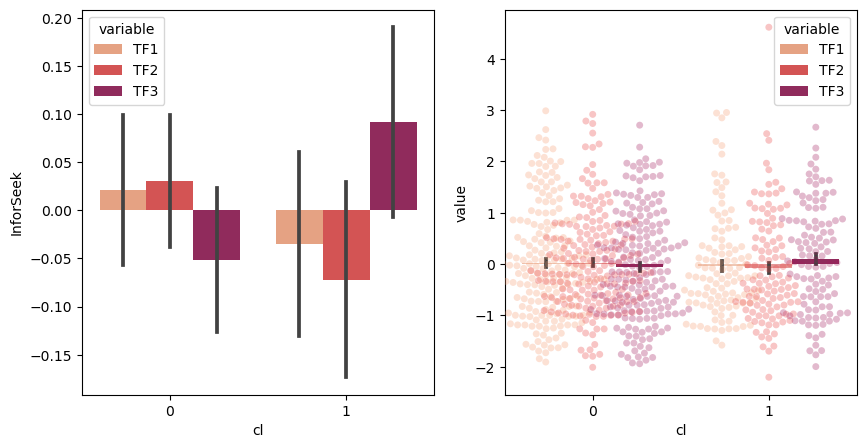

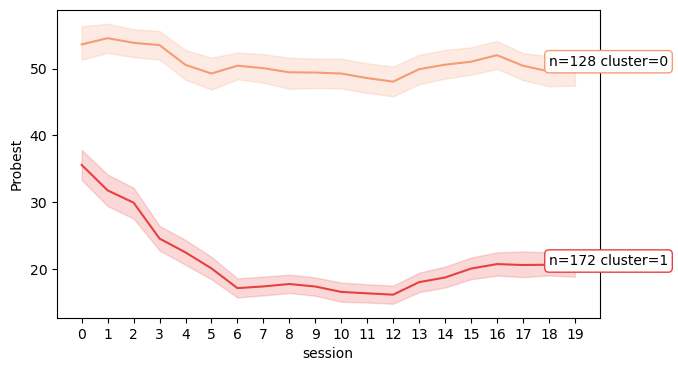

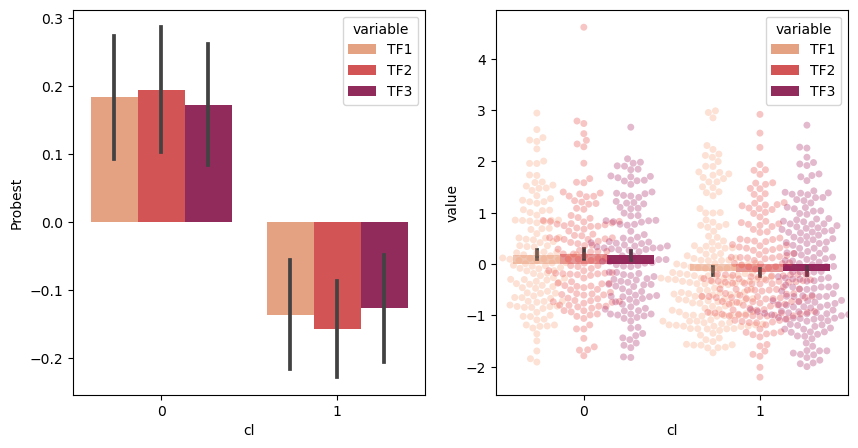

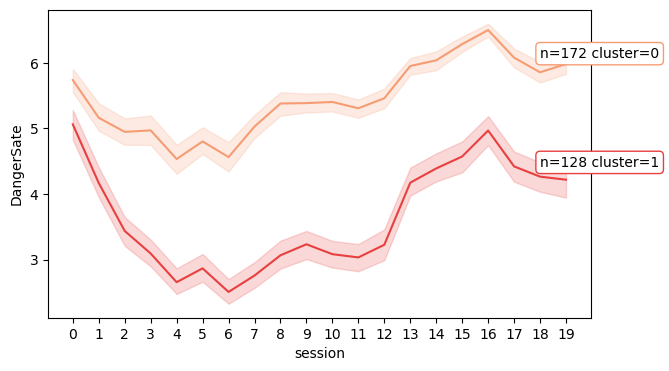

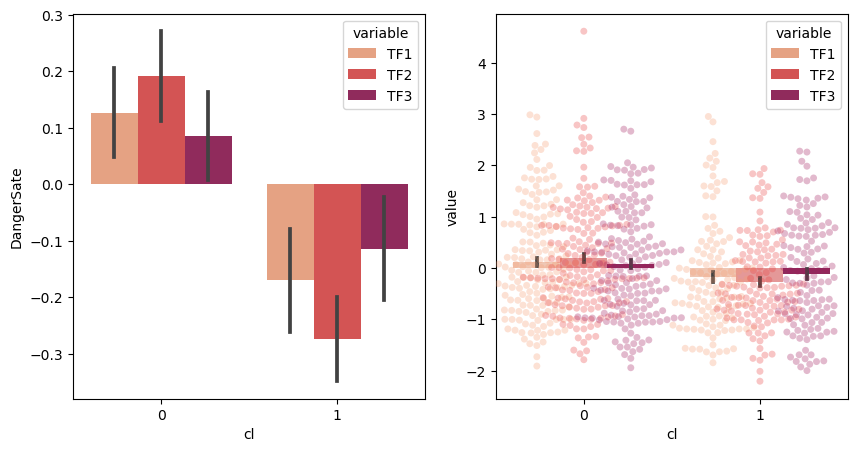

In [8]:

for depvar in vars:
    print(depvar)
    tdf = df.loc[:,[depvar]+["session", "PROLIFICID"]]
    tdf = tdf.pivot(index='PROLIFICID', columns='session', values=depvar).add_prefix('sess')

    # Vrey important, otherwise clustering doesn't work! 
    tdf = tdf.interpolate(method='linear', axis=1)

    # turn to timeseries data type
    ts = to_time_series(tdf)

    tdf, m = estimate_clusters(ts,tdf, n_clusters=int(cldata.loc[cldata["var"]==depvar, "noclusters"]), metric="euclidean")

    visualize_clusters(df, tdf, m, depvar, tf_short, n_clusters=int(cldata.loc[cldata["var"]==depvar, "noclusters"]))

    #tdf, m = estimate_clusters(ts,tdf, n_clusters=2, metric="euclidean")
    #visualize_clusters(df, tdf, m, depvar, trait_factor_names, n_clusters=2)



In [9]:
int(cldata.loc[cldata["var"]==depvar, "noclusters"])

2

### Fixed number of clusers at 5

In [10]:
n_clusters = 5
for depvar in vars:
    print(depvar)
    tdf = df.loc[:,[depvar]+["session", "PROLIFICID"]]
    tdf = tdf.pivot(index='PROLIFICID', columns='session', values=depvar).add_prefix('sess')

    # Vrey important, otherwise clustering doesn't work! 
    tdf = tdf.interpolate(method='linear', axis=1)

    # turn to timeseries data type
    ts = to_time_series(tdf)

    tdf, m = estimate_clusters(ts, n_clusters=n_clusters, metric="euclidean")

    visualize_clusters(df, tdf, m, depvar, trait_factor_names, n_clusters=n_clusters)




AvoidBeh


TypeError: estimate_clusters() missing 1 required positional argument: 'tdf'